

---

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import os

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("="*80)
print("T1.2: DATA CLEANING AND PREPROCESSING")
print("="*80)

T1.2: DATA CLEANING AND PREPROCESSING


In [2]:
# Load both datasets
sf_df = pd.read_csv('../../data/raw/san francisco.csv')
sd_df = pd.read_csv('../../data/raw/san diego.csv')

# Add city identifier
sf_df['city'] = 'San Francisco'
sd_df['city'] = 'San Diego'

# Combine datasets
df = pd.concat([sf_df, sd_df], ignore_index=True)

print(f"\n📊 Combined Dataset Shape: {df.shape}")
print(f"   - Total Rows: {df.shape[0]:,}")
print(f"   - Total Columns: {df.shape[1]}")


📊 Combined Dataset Shape: (20942, 80)
   - Total Rows: 20,942
   - Total Columns: 80


## 2. Missing Values Analysis


2. MISSING VALUES ANALYSIS

📊 Columns with Missing Values: 43

Top 20 Columns with Most Missing Data:
                      Column  Missing_Count  Missing_Percentage
neighbourhood_group_cleansed          20942          100.000000
            calendar_updated          20942          100.000000
       neighborhood_overview           8491           40.545316
               neighbourhood           8491           40.545316
                  host_about           7838           37.427180
                     license           5496           26.243912
               host_location           4799           22.915672
         review_scores_value           4071           19.439404
      review_scores_location           4071           19.439404
       review_scores_checkin           4071           19.439404
           reviews_per_month           4070           19.434629
      review_scores_accuracy           4070           19.434629
                first_review           4070           19.434629
 

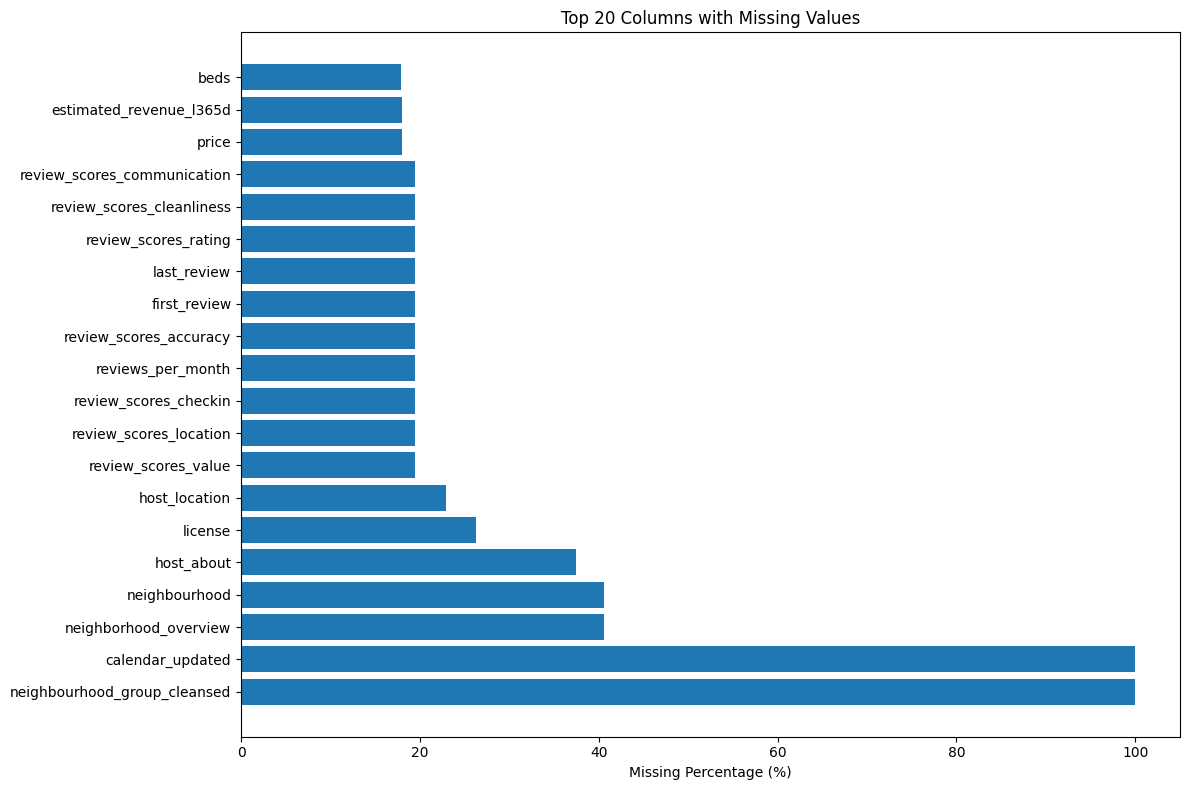


✓ Visualization saved: outputs/figures/missing_values_analysis.png


In [3]:
print("\n" + "="*80)
print("2. MISSING VALUES ANALYSIS")
print("="*80)

# Calculate missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
})

# Filter columns with missing values
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f"\n📊 Columns with Missing Values: {len(missing_df)}")
print("\nTop 20 Columns with Most Missing Data:")
print(missing_df.head(20).to_string(index=False))

# Visualize missing data
plt.figure(figsize=(12, 8))
top_missing = missing_df.head(20)
plt.barh(top_missing['Column'], top_missing['Missing_Percentage'])
plt.xlabel('Missing Percentage (%)')
plt.title('Top 20 Columns with Missing Values')
plt.tight_layout()
plt.savefig('../../outputs/figures/missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: outputs/figures/missing_values_analysis.png")

## 3. Feature Selection - Remove Irrelevant Columns

In [4]:
print("\n" + "="*80)
print("3. FEATURE SELECTION")
print("="*80)

# Define columns to drop (URLs, IDs, text descriptions, etc.)
columns_to_drop = [
    # URLs and IDs
    'listing_url', 'scrape_id', 'picture_url', 'host_url', 
    'host_thumbnail_url', 'host_picture_url',
    
    # Text descriptions (too noisy for initial model)
    'description', 'neighborhood_overview', 'host_about', 'name',
    
    # Redundant or highly specific
    'source', 'calendar_updated', 'last_scraped', 'calendar_last_scraped',
    
    # License (mostly missing or not useful)
    'license',
    
    # Neighbourhood group (if empty)
    'neighbourhood_group_cleansed',
    
    # Bathrooms (we'll use bathrooms_text instead)
    'bathrooms',
    
    # Host verifications (complex nested data)
    'host_verifications',
    
    # Amenities (complex nested data - can be processed later)
    'amenities'
]

# Drop columns that exist in the dataframe
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df_cleaned = df.drop(columns=columns_to_drop)

print(f"\n📊 Dropped {len(columns_to_drop)} columns")
print(f"   - Original: {df.shape[1]} columns")
print(f"   - After dropping: {df_cleaned.shape[1]} columns")
print(f"\n✓ Remaining columns: {df_cleaned.shape[1]}")


3. FEATURE SELECTION

📊 Dropped 19 columns
   - Original: 80 columns
   - After dropping: 61 columns

✓ Remaining columns: 61


## 4. Data Type Conversions and Cleaning

In [5]:
print("\n" + "="*80)
print("4. DATA TYPE CONVERSIONS")
print("="*80)

# 4.1 Clean price column (remove $ and commas)
if 'price' in df_cleaned.columns:
    df_cleaned['price'] = df_cleaned['price'].replace('[\$,]', '', regex=True).astype(float)
    print("\n✓ Cleaned 'price' column (removed $ and commas)")

# 4.2 Convert percentage columns
percentage_cols = ['host_response_rate', 'host_acceptance_rate']
for col in percentage_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].str.rstrip('%').astype(float) / 100
        print(f"✓ Converted '{col}' to decimal")

# 4.3 Convert boolean columns
boolean_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
                'has_availability', 'instant_bookable']
for col in boolean_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].map({'t': 1, 'f': 0})
        print(f"✓ Converted '{col}' to binary (0/1)")

# 4.4 Convert date columns
date_cols = ['host_since', 'first_review', 'last_review']
for col in date_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors='coerce')
        print(f"✓ Converted '{col}' to datetime")

# 4.5 Extract number from bathrooms_text
if 'bathrooms_text' in df_cleaned.columns:
    df_cleaned['bathrooms_numeric'] = df_cleaned['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
    print("\n✓ Extracted numeric bathrooms from 'bathrooms_text'")


4. DATA TYPE CONVERSIONS

✓ Cleaned 'price' column (removed $ and commas)
✓ Converted 'host_response_rate' to decimal
✓ Converted 'host_acceptance_rate' to decimal
✓ Converted 'host_is_superhost' to binary (0/1)
✓ Converted 'host_has_profile_pic' to binary (0/1)
✓ Converted 'host_identity_verified' to binary (0/1)
✓ Converted 'has_availability' to binary (0/1)
✓ Converted 'instant_bookable' to binary (0/1)
✓ Converted 'host_since' to datetime
✓ Converted 'first_review' to datetime
✓ Converted 'last_review' to datetime

✓ Extracted numeric bathrooms from 'bathrooms_text'


## 5. Feature Engineering

In [6]:
print("\n" + "="*80)
print("5. FEATURE ENGINEERING")
print("="*80)

# 5.1 Host experience (years as host)
if 'host_since' in df_cleaned.columns:
    df_cleaned['host_years'] = (pd.Timestamp.now() - df_cleaned['host_since']).dt.days / 365.25
    print("\n✓ Created 'host_years' feature")

# 5.2 Days since first review
if 'first_review' in df_cleaned.columns:
    df_cleaned['days_since_first_review'] = (pd.Timestamp.now() - df_cleaned['first_review']).dt.days
    print("✓ Created 'days_since_first_review' feature")

# 5.3 Days since last review
if 'last_review' in df_cleaned.columns:
    df_cleaned['days_since_last_review'] = (pd.Timestamp.now() - df_cleaned['last_review']).dt.days
    print("✓ Created 'days_since_last_review' feature")

# 5.4 Price per person
if 'price' in df_cleaned.columns and 'accommodates' in df_cleaned.columns:
    df_cleaned['price_per_person'] = df_cleaned['price'] / df_cleaned['accommodates']
    print("✓ Created 'price_per_person' feature")

# 5.5 Reviews per month (if not already present)
if 'reviews_per_month' not in df_cleaned.columns:
    if 'number_of_reviews' in df_cleaned.columns and 'days_since_first_review' in df_cleaned.columns:
        df_cleaned['reviews_per_month'] = (df_cleaned['number_of_reviews'] / 
                                           (df_cleaned['days_since_first_review'] / 30.44))
        print("✓ Created 'reviews_per_month' feature")

# 5.6 Availability rate
if 'availability_365' in df_cleaned.columns:
    df_cleaned['availability_rate'] = df_cleaned['availability_365'] / 365
    print("✓ Created 'availability_rate' feature")

# 5.7 Average review score (if multiple review scores exist)
review_score_cols = [col for col in df_cleaned.columns if 'review_scores_' in col and col != 'review_scores_rating']
if review_score_cols:
    df_cleaned['avg_review_score'] = df_cleaned[review_score_cols].mean(axis=1)
    print("✓ Created 'avg_review_score' feature")

# 5.8 Has reviews flag
if 'number_of_reviews' in df_cleaned.columns:
    df_cleaned['has_reviews'] = (df_cleaned['number_of_reviews'] > 0).astype(int)
    print("✓ Created 'has_reviews' feature")

print(f"\n✓ Total features after engineering: {df_cleaned.shape[1]}")


5. FEATURE ENGINEERING

✓ Created 'host_years' feature
✓ Created 'days_since_first_review' feature
✓ Created 'days_since_last_review' feature
✓ Created 'price_per_person' feature
✓ Created 'availability_rate' feature
✓ Created 'avg_review_score' feature
✓ Created 'has_reviews' feature

✓ Total features after engineering: 69


## 6. Handle Missing Values

In [7]:
print("\n" + "="*80)
print("6. HANDLING MISSING VALUES")
print("="*80)

# 6.1 Drop columns with >50% missing values
missing_threshold = 0.5
missing_pct = df_cleaned.isnull().sum() / len(df_cleaned)
cols_to_drop = missing_pct[missing_pct > missing_threshold].index.tolist()

if cols_to_drop:
    df_cleaned = df_cleaned.drop(columns=cols_to_drop)
    print(f"\n✓ Dropped {len(cols_to_drop)} columns with >{missing_threshold*100}% missing values")
    print(f"   Columns dropped: {cols_to_drop}")

# 6.2 Fill missing values for specific columns
# Numeric columns - fill with median
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

print(f"\n✓ Filled missing numeric values with median")

# Categorical columns - fill with mode or 'Unknown'
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_cleaned[col].isnull().sum() > 0:
        mode_val = df_cleaned[col].mode()
        if len(mode_val) > 0:
            df_cleaned[col].fillna(mode_val[0], inplace=True)
        else:
            df_cleaned[col].fillna('Unknown', inplace=True)

print(f"✓ Filled missing categorical values with mode or 'Unknown'")

# Check remaining missing values
remaining_missing = df_cleaned.isnull().sum().sum()
print(f"\n✓ Remaining missing values: {remaining_missing}")


6. HANDLING MISSING VALUES

✓ Filled missing numeric values with median
✓ Filled missing categorical values with mode or 'Unknown'

✓ Remaining missing values: 8174


## 7. Handle Outliers


7. OUTLIER DETECTION AND HANDLING

✓ Removed 1030 rows with price outliers
   - Price range: $11.00 - $680.00
   - Remaining rows: 19,912


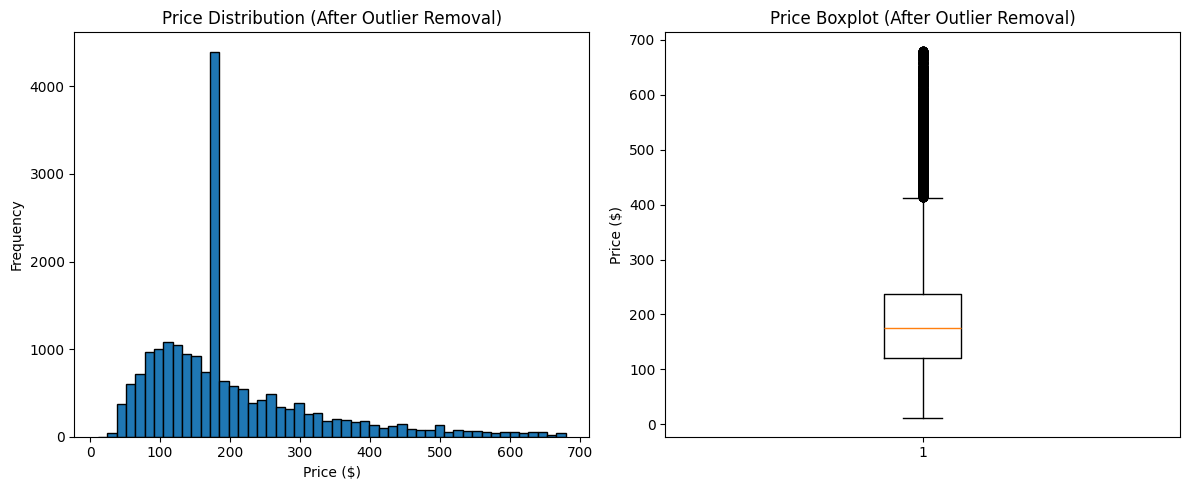


✓ Visualization saved: outputs/figures/price_distribution_cleaned.png


In [8]:
print("\n" + "="*80)
print("7. OUTLIER DETECTION AND HANDLING")
print("="*80)

# Focus on price outliers
if 'price' in df_cleaned.columns:
    # Remove listings with price = 0 or extremely high prices
    initial_rows = len(df_cleaned)
    
    # Remove price = 0
    df_cleaned = df_cleaned[df_cleaned['price'] > 0]
    
    # Remove extreme outliers (using IQR method)
    Q1 = df_cleaned['price'].quantile(0.25)
    Q3 = df_cleaned['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    df_cleaned = df_cleaned[(df_cleaned['price'] >= lower_bound) & 
                            (df_cleaned['price'] <= upper_bound)]
    
    rows_removed = initial_rows - len(df_cleaned)
    print(f"\n✓ Removed {rows_removed} rows with price outliers")
    print(f"   - Price range: ${df_cleaned['price'].min():.2f} - ${df_cleaned['price'].max():.2f}")
    print(f"   - Remaining rows: {len(df_cleaned):,}")

# Visualize price distribution after cleaning
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_cleaned['price'], bins=50, edgecolor='black')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Price Distribution (After Outlier Removal)')

plt.subplot(1, 2, 2)
plt.boxplot(df_cleaned['price'])
plt.ylabel('Price ($)')
plt.title('Price Boxplot (After Outlier Removal)')

plt.tight_layout()
plt.savefig('../../outputs/figures/price_distribution_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: outputs/figures/price_distribution_cleaned.png")

## 8. Encode Categorical Variables

In [9]:
print("\n" + "="*80)
print("8. ENCODING CATEGORICAL VARIABLES")
print("="*80)

# Identify categorical columns (excluding datetime)
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Remove date columns if they're still object type
date_related = ['host_since', 'first_review', 'last_review']
categorical_cols = [col for col in categorical_cols if col not in date_related]

print(f"\n📊 Categorical columns to encode: {len(categorical_cols)}")
print(f"   Columns: {categorical_cols[:10]}...")  # Show first 10

# One-hot encode categorical variables with low cardinality
low_cardinality_cols = []
for col in categorical_cols:
    if df_cleaned[col].nunique() <= 10:  # Only encode if <=10 unique values
        low_cardinality_cols.append(col)

if low_cardinality_cols:
    df_encoded = pd.get_dummies(df_cleaned, columns=low_cardinality_cols, drop_first=True)
    print(f"\n✓ One-hot encoded {len(low_cardinality_cols)} categorical columns")
    print(f"   Columns: {low_cardinality_cols}")
else:
    df_encoded = df_cleaned.copy()

# Drop remaining high-cardinality categorical columns
remaining_categorical = df_encoded.select_dtypes(include=['object']).columns.tolist()
if remaining_categorical:
    df_encoded = df_encoded.drop(columns=remaining_categorical)
    print(f"\n✓ Dropped {len(remaining_categorical)} high-cardinality categorical columns")
    print(f"   Columns: {remaining_categorical}")

print(f"\n✓ Final dataset shape: {df_encoded.shape}")


8. ENCODING CATEGORICAL VARIABLES

📊 Categorical columns to encode: 10
   Columns: ['host_name', 'host_location', 'host_response_time', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'city']...

✓ One-hot encoded 4 categorical columns
   Columns: ['host_response_time', 'neighbourhood', 'room_type', 'city']

✓ Dropped 6 high-cardinality categorical columns
   Columns: ['host_name', 'host_location', 'host_neighbourhood', 'neighbourhood_cleansed', 'property_type', 'bathrooms_text']

✓ Final dataset shape: (19912, 67)


## 9. Create Target Variable (FP Score Classification)


9. CREATE TARGET VARIABLE - FP SCORE CLASSIFICATION

✓ Created FP Score and Value Category
   - Listings with reviews: 19,912
   - FP Score range: 0.08 - 2.23

📊 Value Category Distribution:
value_category
Fair_Value         6773
Poor_Value         6571
Excellent_Value    6568
Name: count, dtype: int64


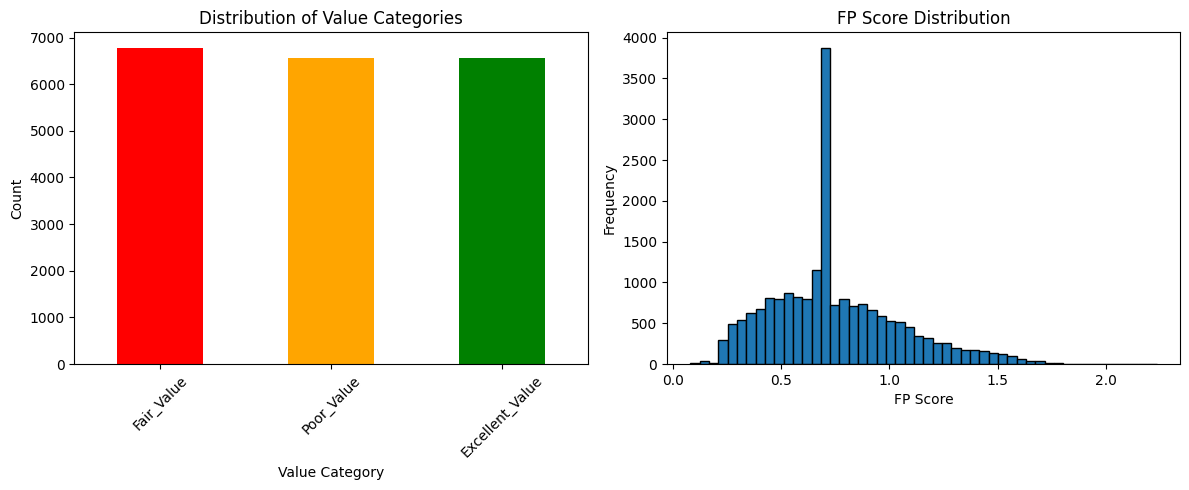


✓ Visualization saved: outputs/figures/value_category_distribution.png


In [10]:
print("\n" + "="*80)
print("9. CREATE TARGET VARIABLE - FP SCORE CLASSIFICATION")
print("="*80)

# Calculate FP Score (Fair Price Score)
# FP Score = (Rating / Price) * 100 (scaled)

if 'review_scores_rating' in df_encoded.columns and 'price' in df_encoded.columns:
    # Filter listings with reviews
    df_with_reviews = df_encoded[df_encoded['review_scores_rating'].notna()].copy()
    
    # Normalize rating (0-5 scale) and price
    df_with_reviews['rating_normalized'] = df_with_reviews['review_scores_rating'] / 20  # Convert 0-100 to 0-5
    df_with_reviews['price_normalized'] = (df_with_reviews['price'] - df_with_reviews['price'].min()) / \
                                          (df_with_reviews['price'].max() - df_with_reviews['price'].min())
    
    # Calculate FP Score
    df_with_reviews['fp_score'] = df_with_reviews['rating_normalized'] / (df_with_reviews['price_normalized'] + 0.1)
    
    # Classify into 3 categories based on FP Score
    fp_33 = df_with_reviews['fp_score'].quantile(0.33)
    fp_67 = df_with_reviews['fp_score'].quantile(0.67)
    
    def classify_value(fp_score):
        if fp_score <= fp_33:
            return 'Poor_Value'
        elif fp_score <= fp_67:
            return 'Fair_Value'
        else:
            return 'Excellent_Value'
    
    df_with_reviews['value_category'] = df_with_reviews['fp_score'].apply(classify_value)
    
    print(f"\n✓ Created FP Score and Value Category")
    print(f"   - Listings with reviews: {len(df_with_reviews):,}")
    print(f"   - FP Score range: {df_with_reviews['fp_score'].min():.2f} - {df_with_reviews['fp_score'].max():.2f}")
    print(f"\n📊 Value Category Distribution:")
    print(df_with_reviews['value_category'].value_counts())
    
    # Visualize distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    df_with_reviews['value_category'].value_counts().plot(kind='bar', color=['red', 'orange', 'green'])
    plt.xlabel('Value Category')
    plt.ylabel('Count')
    plt.title('Distribution of Value Categories')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.hist(df_with_reviews['fp_score'], bins=50, edgecolor='black')
    plt.xlabel('FP Score')
    plt.ylabel('Frequency')
    plt.title('FP Score Distribution')
    
    plt.tight_layout()
    plt.savefig('../../outputs/figures/value_category_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Visualization saved: outputs/figures/value_category_distribution.png")
    
    # Use df_with_reviews for further processing
    df_final = df_with_reviews.copy()
else:
    print("\n⚠️ Warning: 'review_scores_rating' or 'price' not found. Skipping target creation.")
    df_final = df_encoded.copy()

## 10. Prepare Features for Modeling

In [11]:
print("\n" + "="*80)
print("10. PREPARE FEATURES FOR MODELING")
print("="*80)

# Drop columns that shouldn't be used as features
columns_to_exclude = [
    'id', 'host_id', 'value_category', 'fp_score', 
    'rating_normalized', 'price_normalized',
    'review_scores_rating',  # Target leakage
    'host_since', 'first_review', 'last_review'  # Datetime columns
]

# Get feature columns
feature_cols = [col for col in df_final.columns if col not in columns_to_exclude]

# Separate features and target
X = df_final[feature_cols]
y = df_final['value_category']

print(f"\n✓ Features prepared")
print(f"   - Number of features: {X.shape[1]}")
print(f"   - Number of samples: {X.shape[0]:,}")
print(f"   - Target variable: value_category")
print(f"\n📊 Feature columns (first 20):")
print(X.columns.tolist()[:20])


10. PREPARE FEATURES FOR MODELING

✓ Features prepared
   - Number of features: 61
   - Number of samples: 19,912
   - Target variable: value_category

📊 Feature columns (first 20):
['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm']


## 11. Train-Test Split

In [12]:
print("\n" + "="*80)
print("11. TRAIN-TEST SPLIT")
print("="*80)

# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Data split completed")
print(f"   - Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   - Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n📊 Training set class distribution:")
print(y_train.value_counts())
print(f"\n📊 Test set class distribution:")
print(y_test.value_counts())


11. TRAIN-TEST SPLIT

✓ Data split completed
   - Training set: 15,929 samples (80.0%)
   - Test set: 3,983 samples (20.0%)

📊 Training set class distribution:
value_category
Fair_Value         5418
Poor_Value         5257
Excellent_Value    5254
Name: count, dtype: int64

📊 Test set class distribution:
value_category
Fair_Value         1355
Poor_Value         1314
Excellent_Value    1314
Name: count, dtype: int64


## 12. Feature Scaling

In [13]:
print("\n" + "="*80)
print("12. FEATURE SCALING")
print("="*80)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features scaled using StandardScaler")
print(f"   - Training set shape: {X_train_scaled.shape}")
print(f"   - Test set shape: {X_test_scaled.shape}")


12. FEATURE SCALING

✓ Features scaled using StandardScaler
   - Training set shape: (15929, 61)
   - Test set shape: (3983, 61)


## 13. Save Processed Data

In [14]:
print("\n" + "="*80)
print("13. SAVE PROCESSED DATA")
print("="*80)

# Create output directory if it doesn't exist
os.makedirs('../../data/processed', exist_ok=True)

# Save cleaned full dataset
df_final.to_csv('../../data/processed/listings_cleaned_with_target.csv', index=False)
print("\n✓ Saved: data/processed/listings_cleaned_with_target.csv")

# Save train-test splits
X_train.to_csv('../../data/processed/X_train.csv', index=False)
X_test.to_csv('../../data/processed/X_test.csv', index=False)
y_train.to_csv('../../data/processed/y_train.csv', index=False)
y_test.to_csv('../../data/processed/y_test.csv', index=False)

print("✓ Saved: data/processed/X_train.csv")
print("✓ Saved: data/processed/X_test.csv")
print("✓ Saved: data/processed/y_train.csv")
print("✓ Saved: data/processed/y_test.csv")

# Save scaled data as numpy arrays
np.save('../../data/processed/X_train_scaled.npy', X_train_scaled)
np.save('../../data/processed/X_test_scaled.npy', X_test_scaled)

print("✓ Saved: data/processed/X_train_scaled.npy")
print("✓ Saved: data/processed/X_test_scaled.npy")

# Save feature names
feature_names = X_train.columns.tolist()
with open('../../data/processed/feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")

print("✓ Saved: data/processed/feature_names.txt")


13. SAVE PROCESSED DATA

✓ Saved: data/processed/listings_cleaned_with_target.csv
✓ Saved: data/processed/X_train.csv
✓ Saved: data/processed/X_test.csv
✓ Saved: data/processed/y_train.csv
✓ Saved: data/processed/y_test.csv
✓ Saved: data/processed/X_train_scaled.npy
✓ Saved: data/processed/X_test_scaled.npy
✓ Saved: data/processed/feature_names.txt


## 14. Summary Report

In [15]:
print("\n" + "="*80)
print("14. PREPROCESSING SUMMARY REPORT")
print("="*80)

summary = f"""
DATA PREPROCESSING COMPLETED SUCCESSFULLY!
{'='*80}

ORIGINAL DATA:
  - San Francisco: 7,780 listings
  - San Diego: 13,162 listings
  - Combined: {df.shape[0]:,} listings, {df.shape[1]} columns

AFTER CLEANING:
  - Final dataset: {df_final.shape[0]:,} listings, {df_final.shape[1]} columns
  - Features for modeling: {X.shape[1]}
  - Training samples: {X_train.shape[0]:,}
  - Test samples: {X_test.shape[0]:,}

TARGET VARIABLE:
  - Name: value_category
  - Classes: Poor_Value, Fair_Value, Excellent_Value
  - Distribution:
{y.value_counts().to_string()}

KEY STEPS PERFORMED:
  ✓ Removed irrelevant columns (URLs, IDs, text descriptions)
  ✓ Converted data types (price, percentages, booleans, dates)
  ✓ Feature engineering (host_years, price_per_person, etc.)
  ✓ Handled missing values (dropped >50% missing, imputed rest)
  ✓ Removed outliers (price outliers using IQR method)
  ✓ Encoded categorical variables (one-hot encoding)
  ✓ Created target variable (FP Score classification)
  ✓ Train-test split (80-20, stratified)
  ✓ Feature scaling (StandardScaler)

OUTPUT FILES:
  - data/processed/listings_cleaned_with_target.csv
  - data/processed/X_train.csv
  - data/processed/X_test.csv
  - data/processed/y_train.csv
  - data/processed/y_test.csv
  - data/processed/X_train_scaled.npy
  - data/processed/X_test_scaled.npy
  - data/processed/feature_names.txt

VISUALIZATIONS:
  - outputs/figures/missing_values_analysis.png
  - outputs/figures/price_distribution_cleaned.png
  - outputs/figures/value_category_distribution.png

NEXT STEPS:
  1. Exploratory Data Analysis (EDA)
  2. Build baseline models (XGBoost, K-Means)
  3. Model evaluation and comparison
  4. Hyperparameter tuning
  5. Final model selection

{'='*80}
Task 1.2 COMPLETED! Ready for modeling.
{'='*80}
"""

print(summary)

# Save summary to file
os.makedirs('../../outputs/reports', exist_ok=True)
with open('../../outputs/reports/preprocessing_summary.txt', 'w') as f:
    f.write(summary)

print("\n✓ Summary saved to : outputs/reports/preprocessing_summary.txt")


14. PREPROCESSING SUMMARY REPORT

DATA PREPROCESSING COMPLETED SUCCESSFULLY!

ORIGINAL DATA:
  - San Francisco: 7,780 listings
  - San Diego: 13,162 listings
  - Combined: 20,942 listings, 80 columns

AFTER CLEANING:
  - Final dataset: 19,912 listings, 71 columns
  - Features for modeling: 61
  - Training samples: 15,929
  - Test samples: 3,983

TARGET VARIABLE:
  - Name: value_category
  - Classes: Poor_Value, Fair_Value, Excellent_Value
  - Distribution:
value_category
Fair_Value         6773
Poor_Value         6571
Excellent_Value    6568

KEY STEPS PERFORMED:
  ✓ Removed irrelevant columns (URLs, IDs, text descriptions)
  ✓ Converted data types (price, percentages, booleans, dates)
  ✓ Feature engineering (host_years, price_per_person, etc.)
  ✓ Handled missing values (dropped >50% missing, imputed rest)
  ✓ Removed outliers (price outliers using IQR method)
  ✓ Encoded categorical variables (one-hot encoding)
  ✓ Created target variable (FP Score classification)
  ✓ Train-test sp